# A better visualizer for Yamnet

* Prettier visualizations than: https://www.tensorflow.org/hub/tutorials/yamnet


## Download Tensorflow and a test file

In [9]:
%pip install --quiet --upgrade pip
%pip install --quiet tensorflow-hub
!wget -nc https://storage.googleapis.com/audioset/miaow_16k.wav

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
File ‘miaow_16k.wav’ already there; not retrieving.



 ## Import dependencies and try to convince Tensorflow to not crash.

In [10]:
import duckdb
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Audio

In [11]:
# lol, the TF guys make choosing the CPU different every release
# https://stackoverflow.com/questions/37660312/how-to-run-tensorflow-on-cpu
# https://github.com/tensorflow/tensorflow/issues/31135
# and it's too much to ask to have a compatible nvidia-cudnn-cu12 or whatever available.
# Hopefully this works on many versions. 
print(tf.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
tf.config.set_visible_devices([], 'GPU')

2.18.0


## Load a Yamnet model

In [12]:
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
class_map_path = yamnet_model.class_map_path().numpy()
yamnet_class_lookup = duckdb.read_csv(open(class_map_path))
rows = yamnet_class_lookup.fetchall()
idx_to_lbl = {idx:lbl for idx,_mid,lbl in rows}
yamnet_class_lookup.limit(5).df()


,index,mid,display_name
0,0,/m/09x0r,Speech
1,1,/m/0ytgt,"Child speech, kid speaking"
2,2,/m/01h8n0,Conversation
3,3,/m/02qldy,"Narration, monologue"
4,4,/m/0261r1,Babbling


## Classify a sound using Yamnet

In [13]:
y,sr = librosa.load('miaow_16k.wav',sr=16000)
scores, embeddings, spectrogram = yamnet_model(y)
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = idx_to_lbl[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Animal


## The visualization from the TensorFlow docs

* https://www.tensorflow.org/hub/tutorials/yamnet


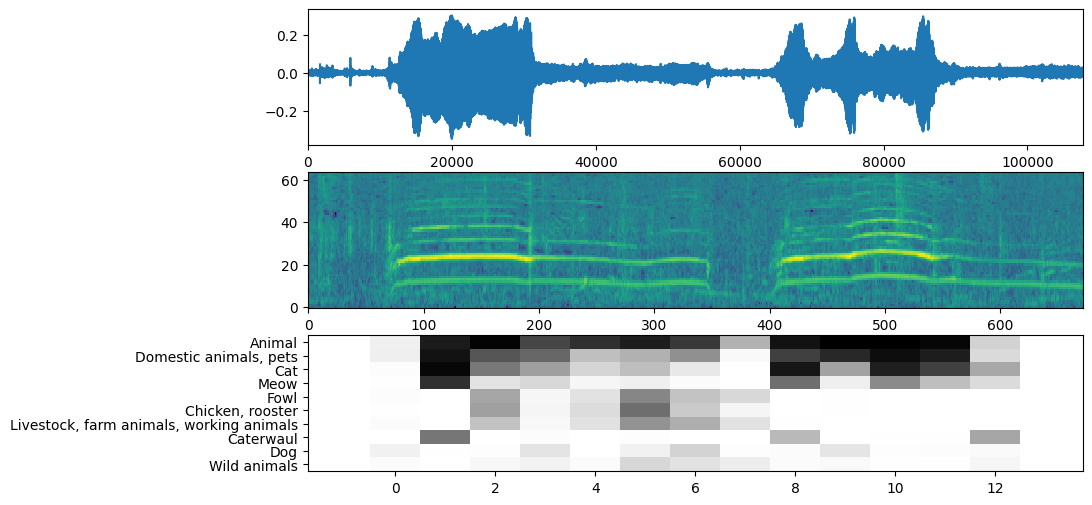

In [23]:
waveform = y
class_names = idx_to_lbl
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))
plt.show()


In [15]:
np.array(scores).shape

(13, 521)

duration is 6.731125 seconds - so expect 13.023177083333334 yamnet bins
similarity scaler 0, 14, torch.Size([23])
similarity scaler 0, 14, torch.Size([23])


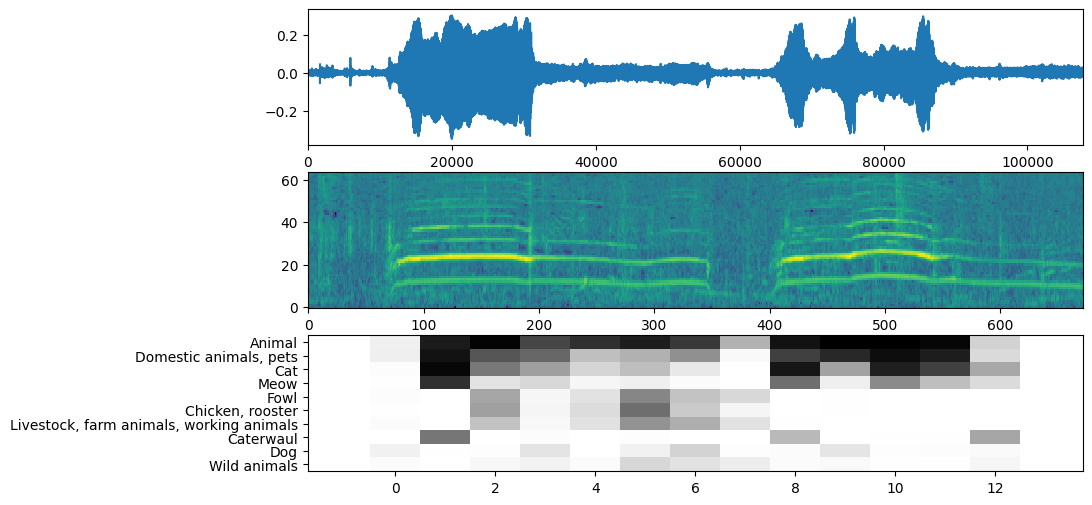

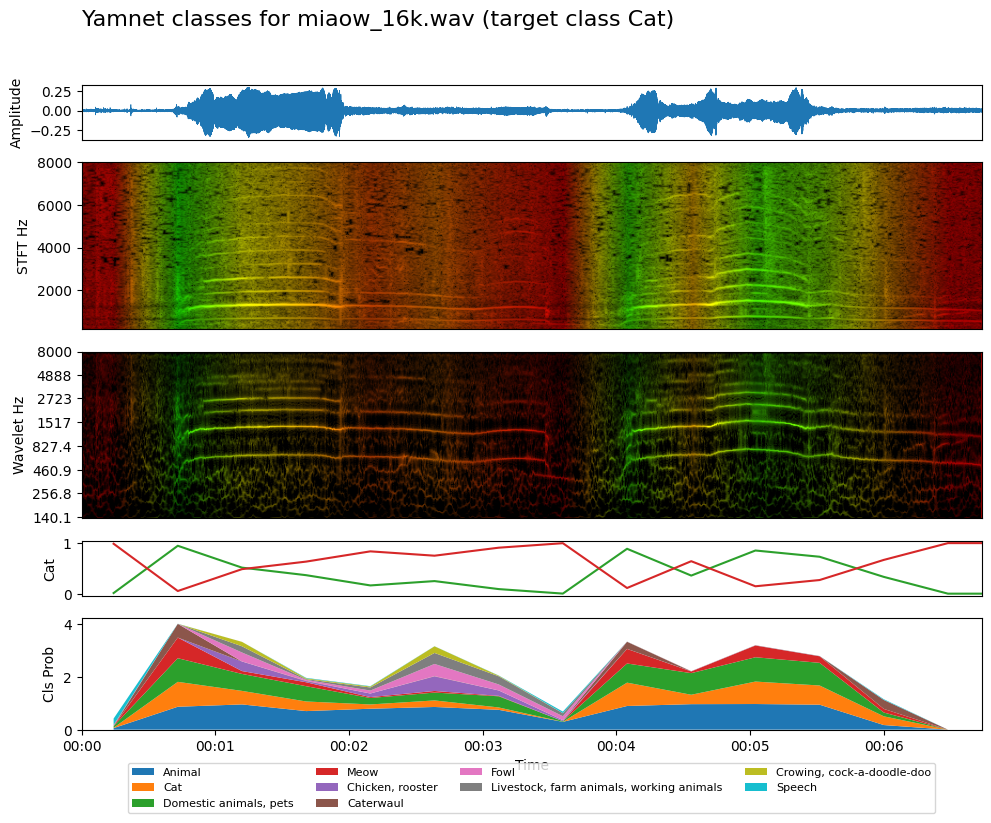

In [ ]:
import audio_classifier_visualizer as acv
import torch
y,sr = librosa.load('miaow_16k.wav',sr=None)
print(f"duration is {y.shape[0]/sr} seconds - so expect {y.shape[0]/sr * 2 / .960 - 1} yamnet bins")

yamnet_feature_rate = 2 / 0.960

max_scores = np.max(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(max_scores)[::-1][:top_n]

labels = [idx_to_lbl[top_class_indices[x]] for x in range(top_n)]

scores_np = np.array(scores)
padded_scores = np.pad(scores_np, ((0, 10), (0, 0)), mode='constant', constant_values=0)
scores_of_interest = padded_scores[:,top_class_indices]
scores_np = scores.numpy()
afv = acv.AudioFileVisualizer(y=y,sr=sr,
                              feature_rate = yamnet_feature_rate,
                              class_probabilities=torch.tensor(scores_of_interest),
                              class_labels = labels,
                              target_class = 1,
                              n_fft=512,
                              freq_range_of_interest = (140,8000)
                              )
afv.visualize_audio_file_fragment(f"Yamnet classes for miaow_16k.wav (target class Cat)",width=10,height=15).show()


## Summary

* I think the above visualization makes it easier to see which parts of the signal Yamnet considered cat-like
* In particular, the very short rising 250-460 Hz fundemental tone, easily visible in the wavelet depiction, was the part that seems to have most strongly triggered Yamnet's cat probability.
